## Demo
In this jupyter notebook we explain how to use our geolocation application. One of the models is too big to be uploaded onto github and so upon first calling the function it will be downloaded and installed in the `models` directory.  Moreover, since it is too big to be uploaded to github before use you need to manually download the following model from [Kaggle](https://www.kaggle.com/datasets/bezemekz/traffic-sign-detection-with-faster-r-cnn-pkl) and moving it into `models`.   

Moreover, the following modules need to be installed in order for the application to work:   
    - tensorflow, version 2.16.1 (this is important, as we found out the hard way that tensorflow is not particularly downwards compatible)
    - logging  
    - numpy  
    - scipy  
    - pandas  
    - pytorch  
    - cv2   
    - PIL   
    - tarfile   
    - torchvision   


We begin by importing the classes `Model`, `GeoLocator` and `FeatureFinder` from `all_models`. We will mainly use `GeoLocator` to obtain a final prediction that incorporates all models, but in theory the methods of `FeatureFinder` can be used to identify whether a certain feature (such as traffic signs, stop signs, cars, buses) are present in a picture. And using `Model` we can instantiate any particular model; either simply the end-to-end model, or also any of the feature based models.


In [1]:
from all_models import Model, GeoLocator, FeatureFinder
import os # We need this so that this demonstration works on any operating system when we want to specify the paths
from PIL import Image

Let's start by making an instance of GeoLocator.

In [2]:
model = GeoLocator()

Let's load a sample picture!

In [3]:
test_picture_london = os.path.join('sample_pictures', 'london_sample.jpg')

Let's see what a picture looks like.

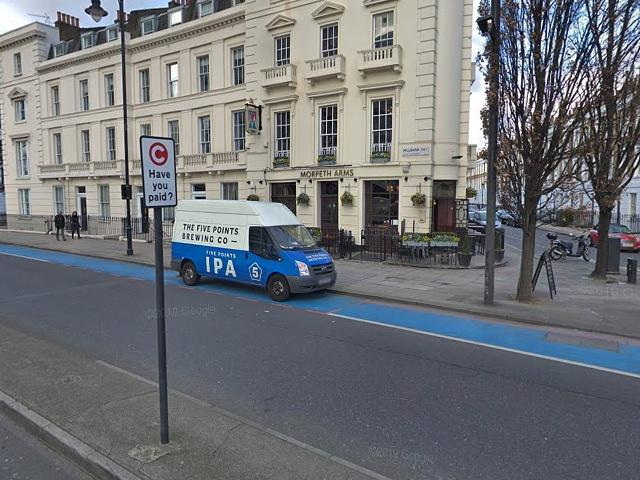

In [4]:
Image.open(test_picture_london)

Now we can use the `predict` method in order to predict the location of where a photo was taken. Let's see if the model can do this with the photo that we are looking at.

In [6]:
model.predict(test_picture_london)

The COCO detector found a car!
The COCO detector found a bus!
The COCO detector found street signs!


'London'

Wow, even I am surprised! I was planning on choosing a good picture obviously, but this was my first attempt..  

The predict method comes with three optional arguments: `want_probabilities`, `proportion_end_to_end` and `score_threshold`.    

If we set `want_probabilities` to `True` then instead of a single prediction the method returns a dictionary whose keys are the city and whose values are the probabilities the model assigns to each city.   

To explain the parameter `proportion_end_to_end` we need to briefly explain how the model works in detail. First of all the image is checked for several features: cars, buses, street signs, stop signs, motorcycles and traffic lights. This is done under the hood by `GeoLocator`, which actually instantiates `FeatureFinder` when it does this. Given the presence of a feature there is a model that predicts where this feature may be found. For example in London we expect many more buses than in Minnesota, perhaps. This is already useful information, but then each neural network tries to find structure within each feature. On the other hand we trained a deeper good neural network on our training set, which we call the end-to-end model. The total prediction is computed as a weighted average out of all the models present. The parameter `proportion_end_to_end` is now the weight with which the end-to-end model is called into the final prediction. Therefore this should be a number between 0 and 1.  

Finall, `score_threshold` can be set to a number between 0 and 1. It determines how sensitive the detector model is in order to include a feature in the prediction. If it is set to a low value, such as 0.1, then the final model will incorporate any feature that is recognized witha certainty of at least 10% into the final model prediction. This parameter is set to 0.6 by default.

Let's see what happens if we set `want_probabilities` = `True`.

In [55]:
model.predict(test_picture_london, want_probabilities = True)

The COCO detector found a car!
The COCO detector found a bus!
The COCO detector found street signs!


{'Madrid': 0.024665801120436474,
 'Phoenix': 0.002977403821732279,
 'Miami': 0.02282905325398814,
 'Boston': 0.01282556628286421,
 'Brussels': 0.06775065833098373,
 'Rome': 0.03419995796276402,
 'Barcelona': 0.043597492075146065,
 'Chicago': 0.010356880680858558,
 'Lisbon': 0.006929458150683513,
 'Melbourne': 0.00942194933491373,
 'Minneapolis': 0.009579415596298399,
 'Bangkok': 0.004199678249513941,
 'TRT': 0.00897707088857571,
 'London': 0.7270231669215428,
 'PRG': 0.00734500188236867,
 'Osaka': 0.004913319666580379,
 'PRS': 0.0024081048612453835}

The model seems pretty confident on it being London. Fair enough. How does this change if we change the `proportion_end_to_end` parameter?

In [9]:
weights = [0.1 + i/10 for i in range(10)]
for weight in weights:
    pred = model.predict(test_picture_london, want_probabilities = True, proportion_end_to_end = weight, verbose = 0)
    city = max(pred, key = pred.get)
    prob = pred[city]
    print(f"If the end_to_end_proportion is set to {weight:.1f} then the model predicts that the image was taken in {city} with a probabilitiy of {100*prob:.1f}%")

If the end_to_end_proportion is set to 0.1 then the model predicts that the image was taken in Barcelona with a probabilitiy of 19.6%
If the end_to_end_proportion is set to 0.2 then the model predicts that the image was taken in London with a probabilitiy of 19.0%
If the end_to_end_proportion is set to 0.3 then the model predicts that the image was taken in London with a probabilitiy of 27.9%
If the end_to_end_proportion is set to 0.4 then the model predicts that the image was taken in London with a probabilitiy of 36.9%
If the end_to_end_proportion is set to 0.5 then the model predicts that the image was taken in London with a probabilitiy of 45.9%
If the end_to_end_proportion is set to 0.6 then the model predicts that the image was taken in London with a probabilitiy of 54.8%
If the end_to_end_proportion is set to 0.7 then the model predicts that the image was taken in London with a probabilitiy of 63.8%
If the end_to_end_proportion is set to 0.8 then the model predicts that the imag

In this example it seems like the feature based models are not necessarily improving the performance.  

If we wanted to call just the end-to-end model, or a particular feature model we can do this by creating an instance of `Model`.   
Below we create two instances: One end-to-end model, and one classifier based on buses.

In [50]:
end_to_end = Model()
bus_classifier = Model('buses')

In [51]:
end_to_end.predict(test_picture_london)

'London'

As expected the end-to-enb model gives us the correct answer.

In [52]:
bus_classifier.predict(test_picture_london)

'Madrid'

Unfortunately, the bus classifier didn't give us the correct answer. Let's examine how certain it is about being in Madrid here.

In [25]:
bus_classifier.predict(test_picture_london, want_probabilities = True)

{'Madrid': 0.27732575,
 'Phoenix': 0.018789202,
 'Miami': 0.10319704,
 'Boston': 0.021862915,
 'Brussels': 0.09707477,
 'Rome': 0.11219001,
 'Barcelona': 0.09722138,
 'Chicago': 0.035704903,
 'Lisbon': 0.014622087,
 'Melbourne': 0.04427689,
 'Minneapolis': 0.024062961,
 'Bangkok': 0.020536877,
 'TRT': 0.069022276,
 'London': 0.021142403,
 'PRG': 0.025765035,
 'Osaka': 0.011682008,
 'PRS': 0.005523468}

It seems like the model is not too sure about Madrid, however London is not particularly high up on that list. Probably it was expecting a red doubledecker...   

In general, the feature based classifiers are not so good indiviaully, but the idea is to have a larger ensemble of feature based classifiers to produce really strong models. Due to time and computational restrictions, we couldn't quite refine this ensemble too much, but we still get a nice performance of around 64% accuracy in total!

Here is where the demo ends. Feel free to play around with trying the model on different pictures! I am loading the pictures in the sample data into a dictionary below:

In [45]:
pictures = {}
for city in os.listdir('sample_pictures'):
    if city[0] != '.' and city[-4] != '.':
        pictures[city] = [os.path.join('sample_pictures', city, file) for file in os.listdir(os.path.join('sample_pictures', city)) if file[0] != '.']

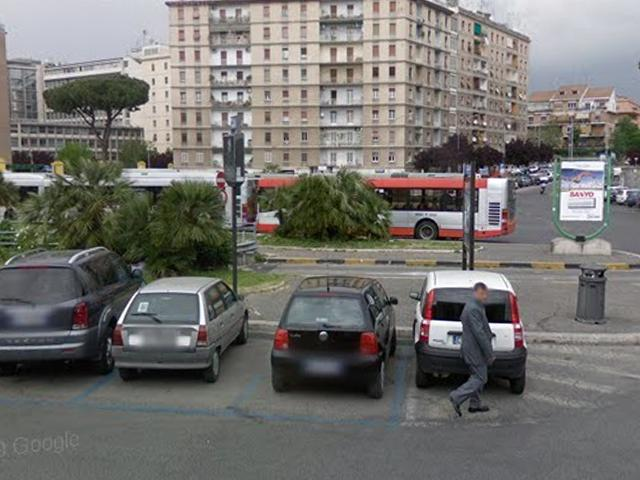

In [59]:
Image.open(pictures['Rome'][0])

And now you can try and make predictions using the model!

In [62]:
model.predict(pictures['Rome'][1])

The COCO detector found a car!
The COCO detector found a bus!


'Rome'